In [10]:
import pandas as pd
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()
import matplotlib.pyplot as plt
from datetime import datetime

# the TWAP must be done over a 1week windows using 4h candles
# The DATA is retrieve from coingecko API since it's the only one free and reliable
# Candle's body:
#   1 - 2 days: 30 minutes
#   3 - 30 days: 4 hours
#   31 and before: 4 days
# The data is delivered: [UNIXTIME, OPEN, HIGH, LOW, CLOSED]


# The script will start retrieve the last 30days of information. The first information present in the csv file start from 12/12/2021.
# After read the Data it load the old information present in coingecko_spiritswap_TWAP.csv and write the new one (if a week is passed!)
# There is no need to update or whatever, just run it at least once a month please

In [11]:
def get_OHLC_Data(token, days ):

    token = str(token).lower() #lower the string, case sensitive
    ohlc = cg.get_coin_ohlc_by_id(token, 'usd', days)


    return ohlc


In [12]:
def findLastTime(tempTime, lastTime):
    for i in range(len(tempTime)):
        if(tempTime[i]/1000 >= lastTime):
            break
    return i

In [13]:
# get data from coinbase

TWAP_Window = 604800 #1week in seconds, if you want you can modify this paramater to increase/decrease the twap window
ohlcData = get_OHLC_Data('spiritswap', 30)
dailySection  = len(ohlcData)

# preapre lists
tempTimeArray = list()
timeArray = list()
TWAPArray = list()
twapRangeArray = list()
AverageSection = list()

In [14]:
# retrieve and prepare data
for i in range(dailySection):

    # retrieve the data in the list
    tempData = ohlcData[i]
    timestamp = tempData[0]
    open = tempData[1]
    high = tempData[2]
    low = tempData[3]
    close = tempData[4]
    # print("i: %d\tOpen: %d\tHigh: %d\tLow: %d\tClose: %d" % (i, open, high, low, close), end='\r')

    # Average of each day’s price = (Open + High + Low + Close)/4
    AverageSection.append( (open + high + low + close) /4 )
    tempTimeArray.append ( timestamp )


In [15]:
start = 0
deltaTime = (tempTimeArray[1] - tempTimeArray[0]) /1000 # time in ms! 
pointCounter = int(TWAP_Window/deltaTime)               # cast as int remove floating zeros

In [16]:
# find TWAP over 1 week window
for i in range(start, len(AverageSection)):
    
    if (i%pointCounter == 0) and i > 0:
        tempValue = 0
        for k in range(pointCounter):
            tempValue += AverageSection[i-k]
        
        TWAPArray.append(tempValue/k)
        timeArray.append(tempTimeArray[i-k]/1000) # time in ms!
        initRange = str( datetime.fromtimestamp(tempTimeArray[i-k]/1000) )
        endRange = str( datetime.fromtimestamp(tempTimeArray[i-k]/1000 + TWAP_Window) )
        twapRangeArray.append( initRange + " _To_ " + endRange )
    

In [17]:
# zip the data
finalList = list(zip(timeArray,twapRangeArray, TWAPArray))
# create data frame
pandasData = pd.DataFrame(finalList, columns=['day','TWAP Range', 'twap'])
# pandas add always an index, name it counter
pandasData.index.name = 'counter'
# write data to cs
pandasData.to_csv("./csvData/" + "coingecko_" +"spiritswap_TWAP.csv", sep=',', encoding='utf-8')
print(pandasData)

                  day                                    TWAP Range      twap
counter                                                                      
0        1.640059e+09  2021-12-21 05:00:00 _To_ 2021-12-28 05:00:00  0.141509
1        1.640664e+09  2021-12-28 05:00:00 _To_ 2022-01-04 05:00:00  0.175666
2        1.641269e+09  2022-01-04 05:00:00 _To_ 2022-01-11 05:00:00  0.205429
3        1.641874e+09  2022-01-11 05:00:00 _To_ 2022-01-18 05:00:00  0.286549


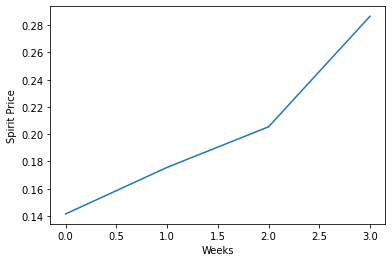

In [18]:
# plot the data
plt.plot(TWAPArray)
plt.xlabel('Weeks')
plt.ylabel('Spirit Price')
plt.show()